# Correlation Length in Ballistic Deposition
## Packages

In [14]:
include("../BallisticDeposition.jl")
using Plots, ColorSchemes, LaTeXStrings, Statistics, DelimitedFiles
import PyPlot as plt

## Configurations

In [15]:
figpath = "../../fig/ballistic-deposition/"
rcParams = plt.PyDict(plt.matplotlib["rcParams"])
rcParams["text.usetex"] = true

true

## Visualization of a Single Tree

In [3]:
"""
Find left and right side of isolated tree on the 1D surface
"""
function bdleftright(surface)
    left = 1
    while surface[left] == 0
        left += 1
    end
    right = length(surface)
    while surface[right] == 0
        right -= 1
    end

    return left, right
end

bdleftright

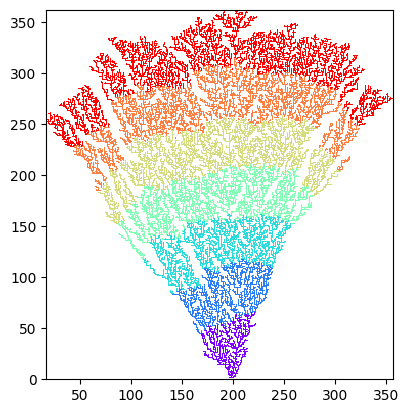

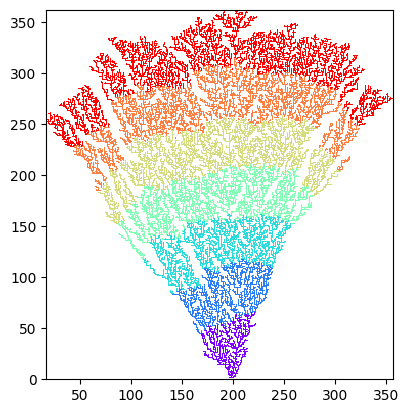

In [6]:
# initial "seed"
len = 400
surface = zeros(Integer, len)
surface[len ÷ 2] = 1

grids = [BallisticDeposition.bdisofull!(surface, 1000i) for i in 1:7]
left, right = bdleftright(surface)

fig, ax = plt.subplots()
ax.set_xlim(left, right)
ax.set_ylim(0, maximum(surface))

rainbow = plt.get_cmap("rainbow")
for i in 7:-1:1
    ax.imshow(grids[i], cmap=plt.ColorMap(vcat([1 1 1 0],
        collect(rainbow((i - 1) / 6))')), interpolation="nearest")
end

display(fig)
plt.savefig(figpath * "bd-iso-vis.pdf", bbox_inches="tight")

## Correlation

In [16]:
"""
Apply bdiso! for time on surface and return new width
"""
function growbdtree!(surface, time)
    BallisticDeposition.bdiso!(surface, time)
    left, right = bdleftright(surface)
    return right - left + 1
end

growbdtree!

In [17]:
len, time, samples, runs = 10^4, 10^4, 20, 1000

times = [convert(Integer, ceil(ℯ^t)) for t in range(3, log(time), length=samples)]
timelog = log.(times)

20-element Vector{Float64}:
 3.044522437723423
 3.332204510175204
 3.6635616461296463
 3.9889840465642745
 4.31748811353631
 4.634728988229636
 4.962844630259907
 5.288267030694535
 5.616771097666572
 5.942799375126701
 6.269096283706261
 6.595780513961311
 6.922643891475888
 7.249215057114389
 7.576097340623111
 7.903226808730733
 8.229777750081887
 8.556798446008598
 8.883501584323207
 9.210440366976517

In [20]:
widthavg, widthσ = zeros(samples), zeros(samples)
widths = zeros(samples)

for run in 1:runs
    surface = zeros(Integer, len)
    surface[len ÷ 2] = 1

    width = growbdtree!(surface, times[1])
    widths[1] = width
    for i in 2:samples
        width = growbdtree!(surface, times[i] - times[i - 1])
        widths[i] = width
    end

    widthavg += widths
    widthσ += widths.^2
end

widthavg = widthavg ./ runs
widthσ = .√(widthσ ./ runs - widthavg)

open("bd-iso.txt", "w") do io
    writedlm(io, [times widthavg widthσ])
end

In [19]:
# load data from file
data = readdlm("bd-iso.txt")
times, widthavg, widthσ = data[:, 1], data[:, 2], data[:, 3]
times = Vector{Integer}(times)

20-element Vector{Integer}:
    21
    28
    39
    54
    75
   103
   143
   198
   275
   381
   528
   732
  1015
  1407
  1951
  2706
  3751
  5202
  7212
 10001

In [21]:
widthlog = log.(widthavg)
errorbar = widthσ ./ widthavg - (widthσ ./ widthavg).^2 ./ 2

growth, coeff = hcat(timelog, ones(samples)) \ widthlog
error = √(sum(x->x^2, widthlog - growth * timelog .- coeff) / (samples - 2)
    / sum(x->x^2, timelog .- mean(timelog)))

print(growth, error)

0.52159185933051870.0019231118933116752

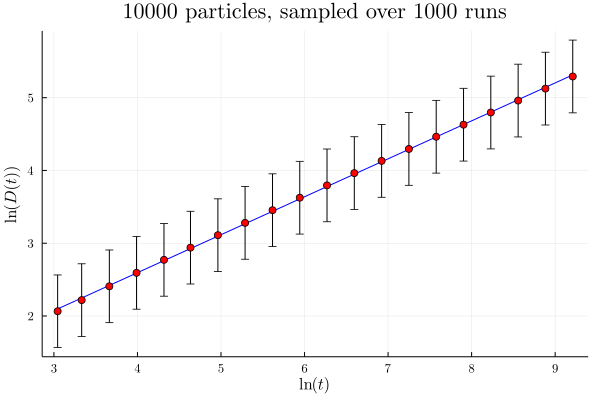

In [22]:
p = plot(x -> growth * x + coeff, timelog[1], timelog[end], color=:blue,
    xlabel=L"\mathrm{ln}(t)", ylabel=L"\mathrm{ln}(D(t))",
    title="$time particles, sampled over $runs runs",
    legend=false, fontfamily="Computer Modern")
scatter!(p, timelog, widthlog, color=:red, yerr=errorbar)

savefig(p, figpath * "bd-correlation.pdf")
display(p)